## Scipy

Find the minimum of the Mutual Information-like function:

$$f(x_1,x_2,x_3) = log\left(\frac{x_1\cdot N}{(x_1+x_3)(x_1+x_2)}\right)$$

subject to the constraint that (a) 3-D points are restricted within a ball of radius r=8 centered at c = (8,8,4), (b) $x_1+x_2+x_3 = N$ for known N and (c) ${x_1, x_2, x_3} \in \mathbb{0,1,2,3,...,30}$.

In [5]:
import numpy as np
import math
from scipy.optimize import minimize

In [6]:
## Selecting only integer values (added as constraints)

# Define objective function
def mi_like_function(x, N=20):
    """
    f(x1,x2,x3) = log( (x1 * N) / ((x1 + x3)*(x1 + x2)) ).
    Return +inf if the expression is invalid or zero to avoid log(0).
    """
    x1, x2, x3 = x
    numerator = x1 * N
    denominator = (x1 + x3)*(x1 + x2)

    # If numerator or denominator <= 0, log(...) -> -inf 
    if numerator <= 0 or denominator <= 0:
        return float("inf")
    return math.log(numerator / denominator)

# lambda to minimize(...) that calls this with a given N

# Constraints 

# (a) Ball constraint: distance((x1,x2,x3), (8,8,4)) <= 8
#  r^2 - sum((x - c)^2) >= 0
center = np.array([8.0, 8.0, 4.0])
radius = 8.0
def constraint_ball(x):
    return radius**2 - np.sum((x - center)**2)

ball_constr = {"type": "ineq", "fun": constraint_ball}

# (b) Plane constraint: x1 + x2 + x3 = N
#  x1 + x2 + x3 - N = 0
N = 20
def constraint_plane(x):
    return np.sum(x) - N

plane_constr = {"type": "eq", "fun": constraint_plane}

# (c) Force integrality by constraining fractional part = 0
# max(x[i] - floor(x[i])) = 0
def constraint_integers(x):
    frac_parts = x - np.floor(x)
    # if everything has 0 fractional part, max(frac_parts) = 0
    return 0.0 - np.max(frac_parts)

int_constr = {"type": "eq", "fun": constraint_integers}

# Bounds
# x1, x2, x3 each in [0, 30]
bnds = [(0, 30)]*3

# Starting point
# Must obey sum = N and meet all constrains(inside the ball, plus integer) x1=10, x2=10, x3=0
# That has sum=20, distance from (8,8,4) ~ sqrt(4 + 4 +16)= sqrt(24)=4.9 < 8, so it's inside the ball.
x0 = np.array([10.0, 10.0, 0.0])

# Solve
constraints = [ball_constr, plane_constr, int_constr]


def random_feasible_point(N=20, center=(8,8,4), radius=8):
    """
    Generate a random integer triple (x1,x2,x3) inside the ball and summing to N
    for use as a starting guess. We'll do a small attempt to find a feasible one.
    """
    for _ in range(1000):
        x1 = np.random.randint(0, 31)
        x2 = np.random.randint(0, 31)
        x3 = N - x1 - x2
        if 0 <= x3 <= 30:
            dist_sq = (x1-center[0])**2 + (x2-center[1])**2 + (x3-center[2])**2
            if dist_sq <= radius**2:
                return np.array([float(x1), float(x2), float(x3)])
    return np.array([10.0,10.0,0.0])  # fallback

best_fun = float("inf")
best_sol = None

# Try multiple random starts
n_starts = 20
for i in range(n_starts):
    x0 = random_feasible_point(N=N, center=center, radius=radius)
    res = minimize(
        fun=lambda xx: mi_like_function(xx, N),
        x0=x0,
        method="SLSQP",   
        bounds=bnds,
        constraints=constraints,
        options={"maxiter": 500}
    )
    
    if res.fun < best_fun:
        best_fun = res.fun
        best_sol = res

# Print final result after multi‐start
print("\nBest solution found after multiple starts:")
print("x1, x2, x3 =", best_sol.x)
print("Minimum f-value:", best_sol.fun)
print("Solver success:", best_sol.success, "| Status:", best_sol.message)

scipy_point = best_sol.x
scipy_val = best_sol.fun


Best solution found after multiple starts:
x1, x2, x3 = [ 2. 11.  7.]
Minimum f-value: -1.0732944806838198
Solver success: False | Status: Singular matrix C in LSQ subproblem


In [7]:
## Checking solution with brute force approach as sample size is small

def f(x1, x2, x3, N):
    """
    Mutual-information-like function:
      f(x1,x2,x3) = log((x1 * N) / ((x1 + x3)*(x1 + x2)))
    Returns +inf if numerator or denominator <= 0 (invalid).
    """
    numerator = x1 * N
    denominator = (x1 + x3)*(x1 + x2)
    if numerator <= 0 or denominator <= 0:
        return float("inf") 
    return math.log(numerator / denominator)

def brute_force_min(N=20):
    """
    Brute-force search over x1,x2,x3 ∈ {0..30} to find the global minimum of f,
    subject to:
      1) x1 + x2 + x3 = N
      2) distance((x1,x2,x3),(8,8,4)) <= 8
    """
    best_val = float("inf")
    best_point = None

    for x1 in range(31):
        for x2 in range(31):
            x3 = N - x1 - x2
            if x3 < 0 or x3 > 30:
                continue  # violates the plane or integer range

            # Check the ball constraint
            dist_sq = (x1-8)**2 + (x2-8)**2 + (x3-4)**2
            if dist_sq > 8**2:  
                continue

            # Evaluate f
            val = f(x1, x2, x3, N)
            if val < best_val:
                best_val = val
                best_point = (x1, x2, x3)

    return best_point, best_val

# Run the brute-force search
N = 20
best_point, best_val = brute_force_min(N)
print("Brute-force best point:", best_point)
print("Minimum f-value:", best_val)


Brute-force best point: (2, 9, 9)
Minimum f-value: -1.1069110914828049


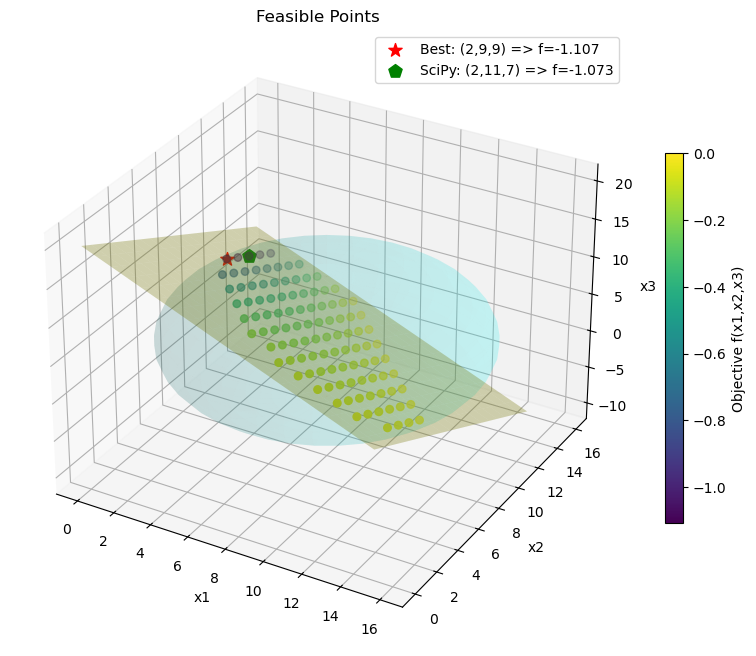

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N = 20
center = np.array([8.0, 8.0, 4.0])
radius = 8.0

def f(x1, x2, x3):
    # f(x1,x2,x3) = log( (x1*N) / ((x1 + x3)*(x1 + x2)) ), +inf if invalid
    numerator = x1 * N
    denominator = (x1 + x3)*(x1 + x2)
    if numerator <= 0 or denominator <= 0:
        return float("inf")
    return math.log(numerator / denominator)
    

# Enumerate feasible integer points
x_vals_3d = []
f_vals_3d = []

for x1 in range(31):
    for x2 in range(31):
        x3 = N - x1 - x2
        if 0 <= x3 <= 30:
            # ball constraint
            dist_sq = (x1-center[0])**2 + (x2-center[1])**2 + (x3-center[2])**2
            if dist_sq <= radius**2:
                val = f(x1, x2, x3)
                if val < float("inf"):
                    x_vals_3d.append([x1, x2, x3])
                    f_vals_3d.append(val)

x_vals_3d = np.array(x_vals_3d)  # shape (M, 3)
f_vals_3d = np.array(f_vals_3d)  # shape (M,)

def plot_sphere(ax, center, radius, n=20, alpha=0.1, color='cyan'):
    u = np.linspace(0, np.pi, n)
    v = np.linspace(0, 2*np.pi, 2*n)

    cx, cy, cz = center
    x_sphere = cx + radius * np.outer(np.sin(u), np.cos(v))
    y_sphere = cy + radius * np.outer(np.sin(u), np.sin(v))
    z_sphere = cz + radius * np.outer(np.cos(u), np.ones_like(v))

    ax.plot_surface(x_sphere, y_sphere, z_sphere, 
                    rstride=1, cstride=1, 
                    color=color, alpha=alpha, edgecolor='none')

def plot_plane(ax, N=20, xlim=(0,15), ylim=(0,15), alpha=0.2, color='yellow'):
    x1s = np.linspace(xlim[0], xlim[1], 20)
    x2s = np.linspace(ylim[0], ylim[1], 20)
    X1, X2 = np.meshgrid(x1s, x2s)
    X3 = N - X1 - X2

    ax.plot_surface(X1, X2, X3, color=color, alpha=alpha, edgecolor='none')




fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of feasible points
p = ax.scatter(x_vals_3d[:,0], x_vals_3d[:,1], x_vals_3d[:,2],
               c=f_vals_3d, cmap='viridis', s=30)
cb = fig.colorbar(p, shrink=0.6)
cb.set_label("Objective f(x1,x2,x3)")

# Sphere
plot_sphere(ax, center=center, radius=radius, n=20, alpha=0.1, color='cyan')

# Plane
plot_plane(ax, N=N, xlim=(0,15), ylim=(0,15), alpha=0.3, color='yellow')

# Mark the best point
bx1,bx2,bx3 = best_point
ax.scatter(bx1, bx2, bx3, color='red', s=100, marker='*',
           label=f"Best: ({bx1},{bx2},{bx3}) => f={best_val:.3f}")

# Mark the scipy minimize point
spx1,spx2,spx3 = scipy_point
ax.scatter(spx1, spx2, spx3, color='green', s=100, marker='p',
           label=f"SciPy: ({spx1:.0f},{spx2:.0f},{spx3:.0f}) => f={scipy_val:.3f}")

# Labels and formatting
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
plt.title("Feasible Points")
ax.legend()
plt.show()

# The SciPy solution is marked with a green pentagon, and the brute-force best point is marked with a red star.
# Restarting the code will give a different solution, as the starting points are random (but all are generally close to the optimal [brute force] solution).
# Rerun the code to see different solutions.